# Feedforward Neural Network Classifier


This notebook demonstrates how feedforward neural networks can solve classification problems that single-layer perceptrons cannot. We will build and train a 2-layer neural network to classify data that is not linearly separable, using PyTorch to implement the model, training loop, and visualization of decision boundaries.

## Import libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

## Generating Data

Here, we generate a dataset consisting of 3 classes in 2 dimensional space, where no two classes are linearly separable.

In [4]:
np.random.seed(352)
torch.manual_seed(0)

N = 100 # number of points per class
C = 3 # number of classes

def generate_data(N, num_class):
    X = np.zeros((2, N*num_class)) # data matrix
    y = np.zeros(N*num_class) # class abels

    for j in range(num_class):
        ix = range(N*j,N*(j+1))
        r = np.linspace(0.0, 1, N) # radius
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
        X[:,ix] = np.c_[r*np.sin(t), r*np.cos(t)].T
        y[ix] = j

    return X.T, y

# Generate data
data, labels = generate_data(N, C)

# # Uncomment to see the shape of data and labels
print("Data shape :", data.shape)
print("Labels shape :", labels.shape)


Data shape : (300, 2)
Labels shape : (300,)


At this point let's visualize the dataset we just generated.

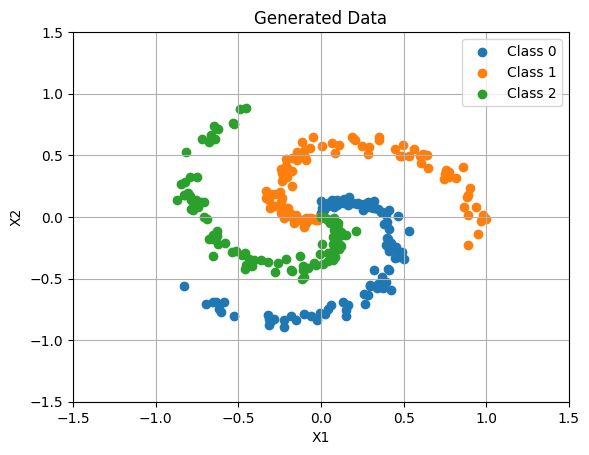

In [5]:
for i in range(C):
  plt.scatter(data[i*N:(i+1)*N, 0], data[i*N:(i+1)*N, 1], label=('Class ' + str(i)))

plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.title("Generated Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)
plt.show()


## DataLoader Implementation


Complete the PointDataset by replacing ```NotImplemented``` with your code


In [6]:
class PointsDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, index):
        # Retrieve the point and label at the given index
        point = self.data[index]
        label = self.labels[index]
        return point, label

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.data)

class PointsDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.transform = lambda x: x  # No transformation by default

    def __iter__(self):
        for batch in super().__iter__():
            yield self.transform(batch)

## Building the Neural Network


<p align="center"> <img src="https://www.ritchievink.com/img/post-9-mlp/nn_diagram_1.png" alt="nn" style="width: 700px;"/> </p>


This implementation builds a model using the layers provided by PyTorch. For more details, refer to: [Building Models with PyTorch](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html). Our model will be described as consisting of the following components:

Linear Layer: $$\mathbf{Z}^{(2)} = \mathbf{W}^{(1)T}\mathbf{X} $$

ReLU Activation: $$\mathbf{A}^{(2)} = \max(\mathbf{Z}^{(2)}, \mathbf{0}) $$

Linear Layer:$$\mathbf{Z}^{(3)} = \mathbf{W}^{(2)T}\mathbf{A}^{(1)} $$

Softmax Activation:$$\mathbf{\hat{Y}} = \mathbf{A}^{(3)} = \text{softmax}(\mathbf{Z}^{(3)})$$


In [7]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim) -> None:
        super(FFNN, self).__init__()

        # Define the first linear layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)

        # Define the second linear layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # First linear layer with ReLU activation
        z2 = self.fc1(x)
        a2 = F.relu(z2)

        # Second linear layer
        z3 = self.fc2(a2)

        # Softmax activation on the output
        y_hat = F.softmax(z3, dim=1)

        return y_hat


## Training the Model


Here, we specify the important hyperparameters for training the model as well as provide a function to plot the decision boundary to help visualize the results after training.

In [8]:
config = {
    "input_dim": 2,
    "hidden_dim": 100,
    "output_dim": C,
    "device": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    "num_epochs": 1000,
    "batch_size": 300,
    "learning_rate": 1,
}

In [9]:
# Visualize function
def plot_decision_boundary(model, points, labels, title="Decision Boundary"):
    model.eval()
    model.to("cpu")
    plt.figure(figsize=(8, 6))

    # Plot the data points
    for label in np.unique(labels):
        label_points = points[labels.flatten() == label]
        plt.scatter(label_points[:, 0], label_points[:, 1], label=('Class ' + str(int(label))))

    # Create grid to evaluate the model
    x_min, x_max = points[:, 0].min() - 1, points[:, 0].max() + 1
    y_min, y_max = points[:, 1].min() - 1, points[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    X0 = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float)
    Z = model(X0).argmax(dim=1)
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.grid(True)
    plt.show()

<b>(1 point) Complete the train function below to train the model. </b>

For more details, refer to [Training with PyTorch](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop) for a more detailed understanding.

In [10]:
def train(config, data, labels):
    # Create dataset and loader
    points_dataset = PointsDataset(data, labels)
    points_dataloader = DataLoader(points_dataset, batch_size=config["batch_size"], shuffle=True)

    # Initialize the model
    model = FFNN(config["input_dim"], config["hidden_dim"], config["output_dim"])
    model.to(config["device"])

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=config["learning_rate"])

    model.train()
    for epoch in range(config["num_epochs"]):
        running_loss = 0
        correct = 0

        for batch_point, batch_label in points_dataloader:
            batch_point = batch_point.to(config["device"])
            batch_label = batch_label.to(config["device"])

            # Forward pass and loss computation
            output = model(batch_point)
            loss = criterion(output, batch_label)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (output.argmax(1) == batch_label).sum().item()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1} | Running Loss: {running_loss/len(points_dataloader)} | Accuracy: {correct/len(points_dataset)}')

    # Plot decision boundary
    plot_decision_boundary(model, data, labels, title="Decision Boundaries")

Epoch 100 | Running Loss: 0.8401604294776917 | Accuracy: 0.6633333333333333
Epoch 200 | Running Loss: 0.7595046758651733 | Accuracy: 0.7766666666666666
Epoch 300 | Running Loss: 0.7039985656738281 | Accuracy: 0.8833333333333333
Epoch 400 | Running Loss: 0.6738969087600708 | Accuracy: 0.9166666666666666
Epoch 500 | Running Loss: 0.6558575630187988 | Accuracy: 0.9333333333333333
Epoch 600 | Running Loss: 0.6431348323822021 | Accuracy: 0.9366666666666666
Epoch 700 | Running Loss: 0.6333969831466675 | Accuracy: 0.95
Epoch 800 | Running Loss: 0.6254771947860718 | Accuracy: 0.95
Epoch 900 | Running Loss: 0.6189144849777222 | Accuracy: 0.9566666666666667
Epoch 1000 | Running Loss: 0.6132678985595703 | Accuracy: 0.9633333333333334


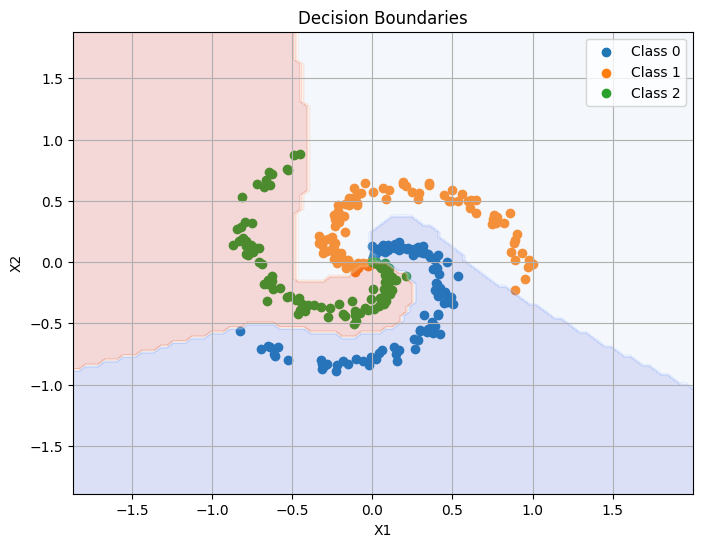

In [11]:
train(config, data, labels)